In [33]:
import os
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, InceptionV3, DenseNet121, Xception, MobileNetV2, EfficientNetB0, NASNetMobile, InceptionResNetV2, VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Average
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from tensorflow.keras.callbacks import EarlyStopping

# Global variables
max_images_per_breed = 300  # Number of images per breed
total_epochs = 10  # Number of epochs

# Set directories
base_dir = os.getcwd()
thesis_dir = os.path.abspath(os.path.join(base_dir, ".."))
models_dir = os.path.join(thesis_dir, 'models')
class_indices_path = os.path.join(thesis_dir, 'class_indices.json')
train_dir = os.path.join(thesis_dir, 'images', 'train')
val_dir = os.path.join(thesis_dir, 'images', 'val')

def create_model(model_type, num_classes):
    if model_type == 'vgg16':
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'resnet50':
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionv3':
        base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'densenet121':
        base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'xception':
        base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'mobilenetv2':
        base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'efficientnetb0':
        base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'nasnetmobile':
        base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'inceptionresnetv2':
        base_model = InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    elif model_type == 'vgg19':
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    else:
        raise ValueError(f"Unknown model type: {model_type}")
    
    # Freeze base model layers
    for layer in base_model.layers:
        layer.trainable = False

    x = Flatten()(base_model.output)
    output = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    
    return model

def create_ensemble(models, input_shape):
    # Create a single shared input for all models
    shared_input = tf.keras.Input(shape=input_shape)
    
    # Pass the shared input to each model and collect the outputs
    model_outputs = [model(shared_input) for model in models]
    
    # Average the outputs
    averaged_output = Average()(model_outputs)
    
    # Create an ensemble model with the shared input and averaged output
    ensemble_model = Model(inputs=shared_input, outputs=averaged_output)
    return ensemble_model

def load_image_paths_and_labels(directory, max_images_per_breed):
    image_paths = []
    labels = []
    for breed in os.listdir(directory):
        breed_path = os.path.join(directory, breed)
        if os.path.isdir(breed_path):
            breed_images = os.listdir(breed_path)[:max_images_per_breed]
            for image_name in breed_images:
                image_paths.append(os.path.join(breed_path, image_name))
                labels.append(breed)
    return image_paths, labels

def train(model_types=['vgg16', 'resnet50', 'inceptionv3']):
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Training directory not found: {train_dir}")
    if not os.path.exists(val_dir):
        raise FileNotFoundError(f"Validation directory not found: {val_dir}")
    
    train_image_paths, train_labels = load_image_paths_and_labels(train_dir, max_images_per_breed)
    val_image_paths, val_labels = load_image_paths_and_labels(val_dir, max_images_per_breed)
    
    train_df = pd.DataFrame({'filename': train_image_paths, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_image_paths, 'class': val_labels})
    
    train_datagen = ImageDataGenerator(rescale=1./255)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_dataframe(
        train_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    val_generator = val_datagen.flow_from_dataframe(
        val_df, x_col='filename', y_col='class', target_size=(224, 224), class_mode='categorical')
    
    num_classes = len(train_generator.class_indices)
    
    # Save class indices to JSON
    with open(class_indices_path, 'w') as f:
        json.dump(train_generator.class_indices, f)

    # Create models for the ensemble
    models = [create_model(model_type, num_classes) for model_type in model_types]

    # Create an ensemble with a shared input
    ensemble_model = create_ensemble(models, input_shape=(224, 224, 3))
    
    # Compile the ensemble model
    ensemble_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=1, restore_best_weights=True)
    
    # Train the ensemble model
    history = ensemble_model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=total_epochs,
        callbacks=[early_stopping]
    )
    
    # Save the ensemble model
    model_save_path = os.path.join(models_dir, f'ensemble_{"_".join(model_types)}.h5')
    ensemble_model.save(model_save_path)
    print(f"Ensemble model saved to: {model_save_path}")
    
    # Plot training and validation accuracy
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))  # Adjust based on the actual number of completed epochs
    
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.show()
    
    # Plot training and validation loss
    plt.figure(figsize=(8, 6))
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()


# The Best Models
We'll first create ensembles by randomly combining the 5 best performing models. We'll take these 5 models and randomly create sets of 3.

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 1044s 3s/step - accuracy: 0.7940 - loss: 1.0023 - val_accuracy: 0.9240 - val_loss: 0.3785
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 977s 3s/step - accuracy: 0.9634 - loss: 0.1668 - val_accuracy: 0.9290 - val_loss: 0.2797
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 981s 3s/step - accuracy: 0.9777 - loss: 0.0920 - val_accuracy: 0.9371 - val_loss: 0.2557
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 979s 3s/step - accuracy: 0.9804 - loss: 0.0700 - val_accuracy: 0.9421 - val_loss: 0.2497
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 975s 3s/step - accuracy: 0.9864 - loss: 0.0494 - val_accuracy: 0.9375 - val_loss: 0.2494
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 974s 3s/step - accuracy: 0.9871 - loss: 0.0467 - val_accuracy: 0.9378 - val_loss: 0.2548


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_nasnetmobile_xception.h5


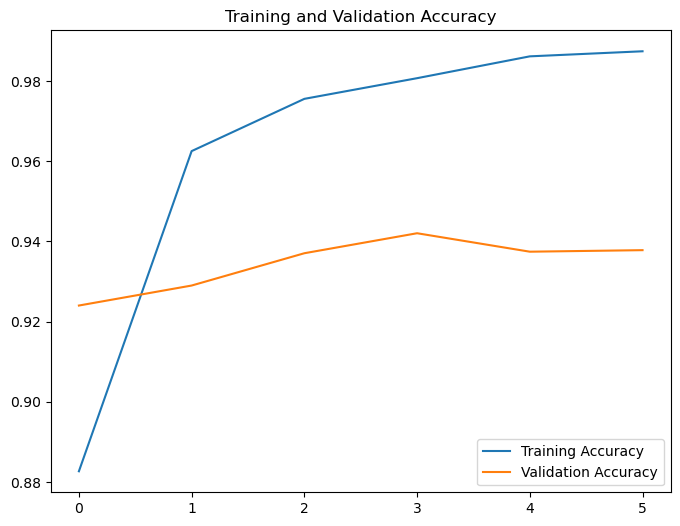

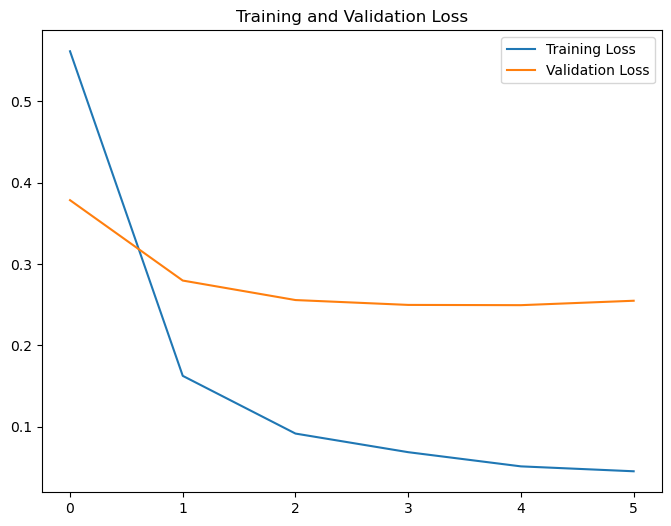

In [34]:
train(['inceptionresnetv2', 'nasnetmobile', 'xception'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 641s 2s/step - accuracy: 0.6591 - loss: 1.6889 - val_accuracy: 0.8668 - val_loss: 0.6266
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 606s 2s/step - accuracy: 0.9497 - loss: 0.3176 - val_accuracy: 0.8960 - val_loss: 0.4251
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 664s 2s/step - accuracy: 0.9737 - loss: 0.1675 - val_accuracy: 0.9091 - val_loss: 0.3812
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 577s 2s/step - accuracy: 0.9848 - loss: 0.1162 - val_accuracy: 0.9125 - val_loss: 0.3621
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 569s 2s/step - accuracy: 0.9890 - loss: 0.0847 - val_accuracy: 0.9152 - val_loss: 0.3508
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9897 - loss: 0.0690 - val_accuracy: 0.9229 - val_loss: 0.3300
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 556s 2s/step - accuracy: 0.9910 - loss: 0.0598 - val_accuracy: 0.9198 - val_loss: 0.3324


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionv3_mobilenetv2_densenet121.h5


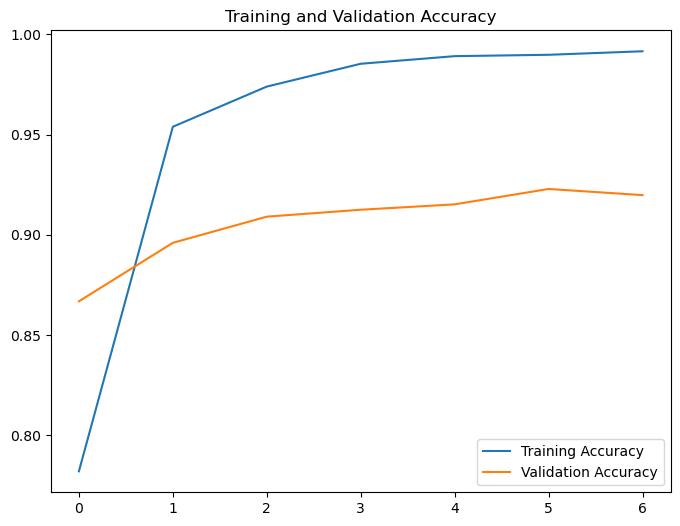

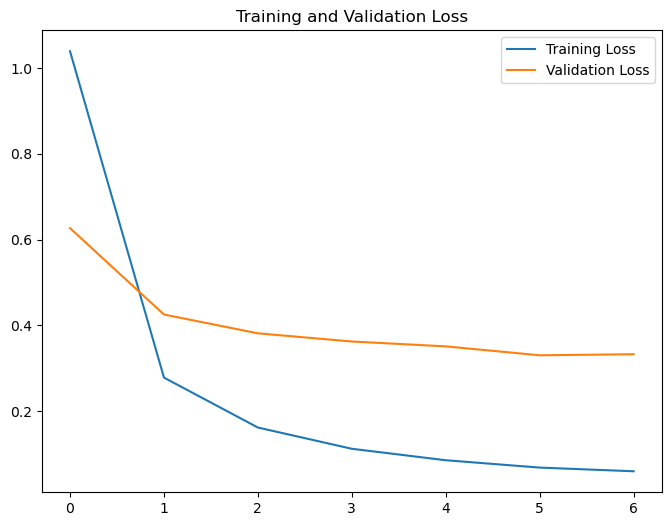

In [35]:
train(['inceptionv3', 'mobilenetv2', 'densenet121'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.7658 - loss: 1.1029 - val_accuracy: 0.9271 - val_loss: 0.3736
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 652s 2s/step - accuracy: 0.9593 - loss: 0.1926 - val_accuracy: 0.9267 - val_loss: 0.3381
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 648s 2s/step - accuracy: 0.9737 - loss: 0.1204 - val_accuracy: 0.9298 - val_loss: 0.3017
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 654s 2s/step - accuracy: 0.9810 - loss: 0.0861 - val_accuracy: 0.9344 - val_loss: 0.2954
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.9843 - loss: 0.0611 - val_accuracy: 0.9332 - val_loss: 0.2865
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 653s 2s/step - accuracy: 0.9872 - loss: 0.0478 - val_accuracy: 0.9325 - val_loss: 0.2695
Epoch 7/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 650s 2s/step - accuracy: 0.9897 - loss: 0.0396 - val_accuracy: 0.9355 - val_loss: 0.2721


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_xception_inceptionv3_nasnetmobile.h5


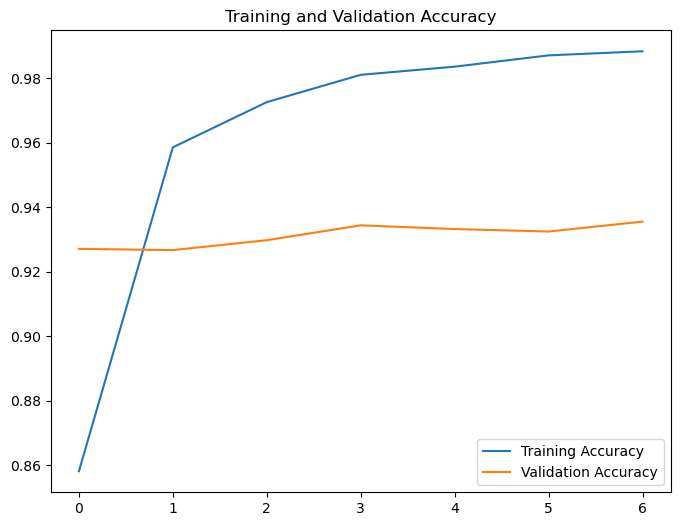

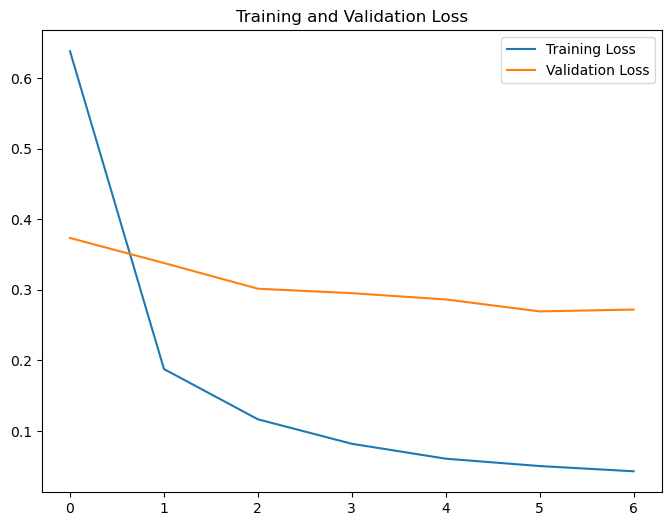

In [36]:
train(['xception', 'inceptionv3', 'nasnetmobile'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 918s 3s/step - accuracy: 0.7802 - loss: 1.1039 - val_accuracy: 0.9091 - val_loss: 0.4271
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 881s 3s/step - accuracy: 0.9671 - loss: 0.1724 - val_accuracy: 0.9248 - val_loss: 0.3417
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 884s 3s/step - accuracy: 0.9792 - loss: 0.0965 - val_accuracy: 0.9286 - val_loss: 0.3091
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 879s 3s/step - accuracy: 0.9831 - loss: 0.0752 - val_accuracy: 0.9279 - val_loss: 0.3232


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_mobilenetv2_inceptionresnetv2_xception.h5


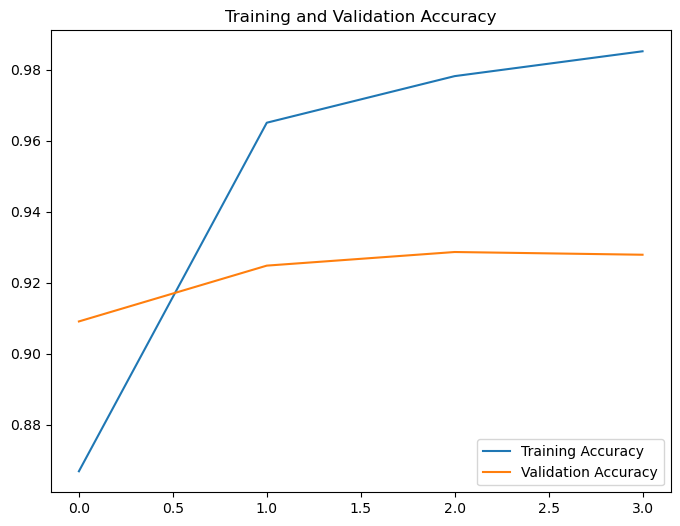

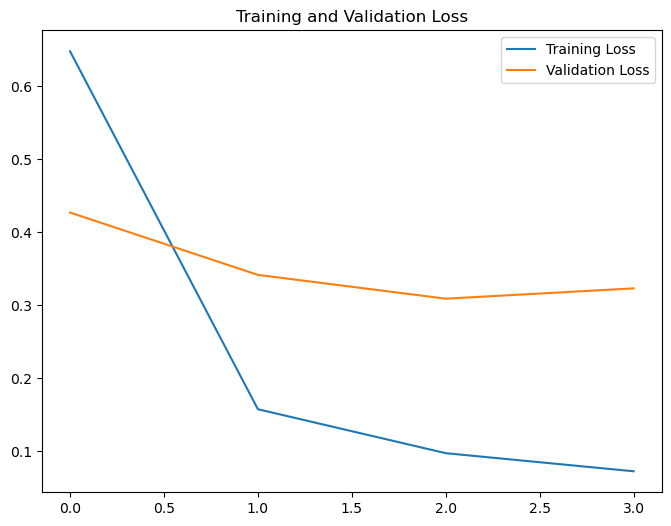

In [37]:
train(['mobilenetv2', 'inceptionresnetv2', 'xception'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 562s 2s/step - accuracy: 0.6861 - loss: 1.5308 - val_accuracy: 0.8810 - val_loss: 0.5860
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 515s 2s/step - accuracy: 0.9534 - loss: 0.3150 - val_accuracy: 0.9202 - val_loss: 0.4465
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 510s 2s/step - accuracy: 0.9781 - loss: 0.2074 - val_accuracy: 0.9087 - val_loss: 0.3947
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.9828 - loss: 0.1638 - val_accuracy: 0.9225 - val_loss: 0.3556
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 509s 2s/step - accuracy: 0.9904 - loss: 0.1322 - val_accuracy: 0.9233 - val_loss: 0.3640


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_nasnetmobile_densenet121_mobilenetv2.h5


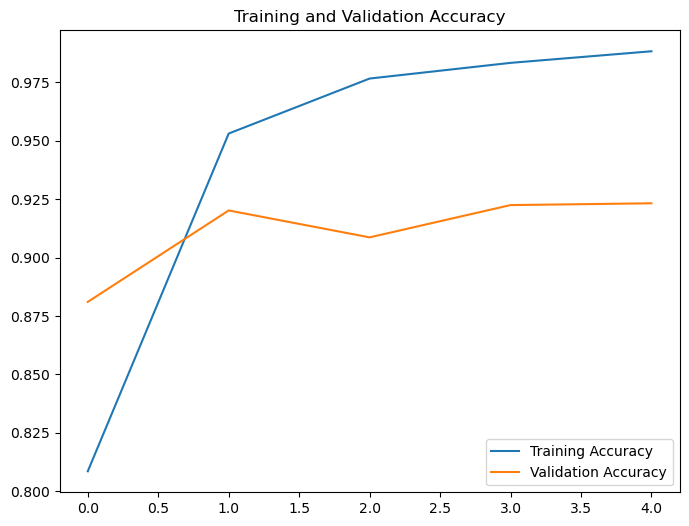

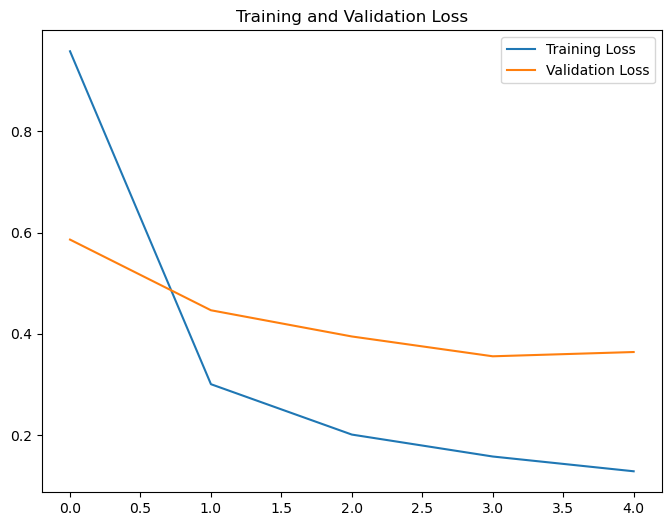

In [38]:
train(['nasnetmobile', 'densenet121', 'mobilenetv2'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 1129s 3s/step - accuracy: 0.7625 - loss: 1.2548 - val_accuracy: 0.9014 - val_loss: 0.5490
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1103s 3s/step - accuracy: 0.9508 - loss: 0.2861 - val_accuracy: 0.9075 - val_loss: 0.4488
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1091s 3s/step - accuracy: 0.9702 - loss: 0.1720 - val_accuracy: 0.9167 - val_loss: 0.3764
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1090s 3s/step - accuracy: 0.9771 - loss: 0.1231 - val_accuracy: 0.9271 - val_loss: 0.3498
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1089s 3s/step - accuracy: 0.9839 - loss: 0.0891 - val_accuracy: 0.9302 - val_loss: 0.3238
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1073s 3s/step - accuracy: 0.9850 - loss: 0.0735 - val_accuracy: 0.9305 - val_loss: 0.3264


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_xception_densenet121.h5


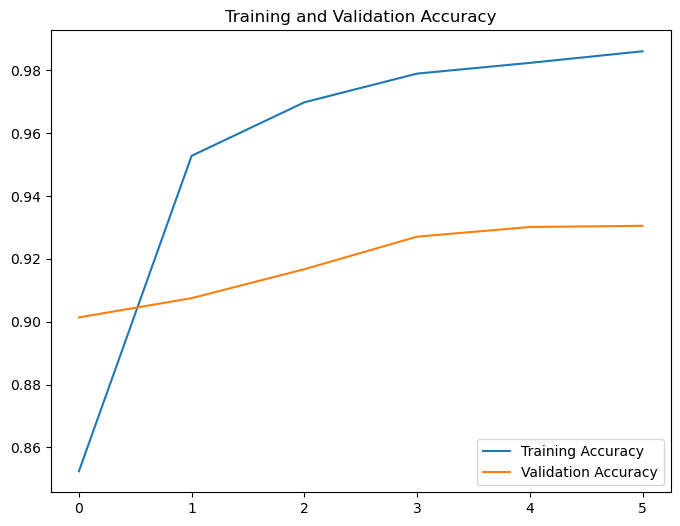

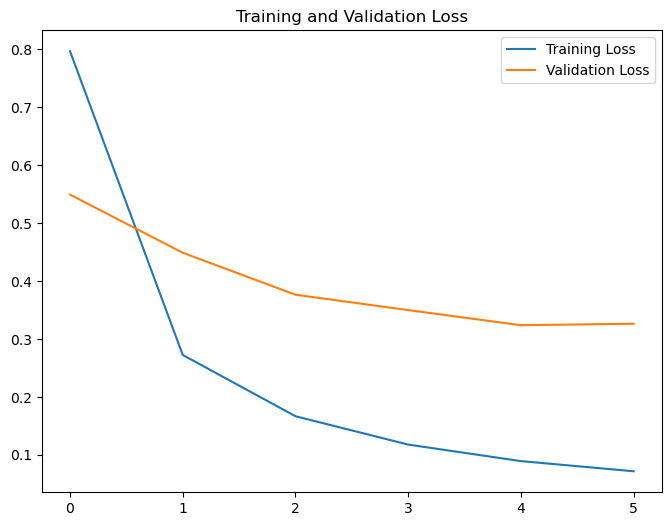

In [39]:
train(['inceptionresnetv2', 'xception', 'densenet121'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 414s 1s/step - accuracy: 0.7243 - loss: 1.3214 - val_accuracy: 0.9060 - val_loss: 0.4749
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9587 - loss: 0.1930 - val_accuracy: 0.9229 - val_loss: 0.3405
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.9797 - loss: 0.1058 - val_accuracy: 0.9240 - val_loss: 0.2955
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 383s 1s/step - accuracy: 0.9865 - loss: 0.0777 - val_accuracy: 0.9298 - val_loss: 0.2886
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 374s 1s/step - accuracy: 0.9856 - loss: 0.0672 - val_accuracy: 0.9351 - val_loss: 0.2879
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 384s 1s/step - accuracy: 0.9902 - loss: 0.0569 - val_accuracy: 0.9286 - val_loss: 0.2912


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionv3_nasnetmobile_mobilenetv2.h5


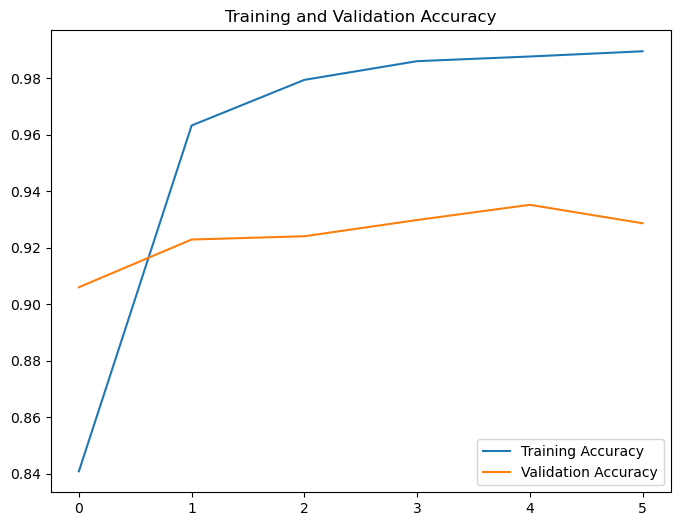

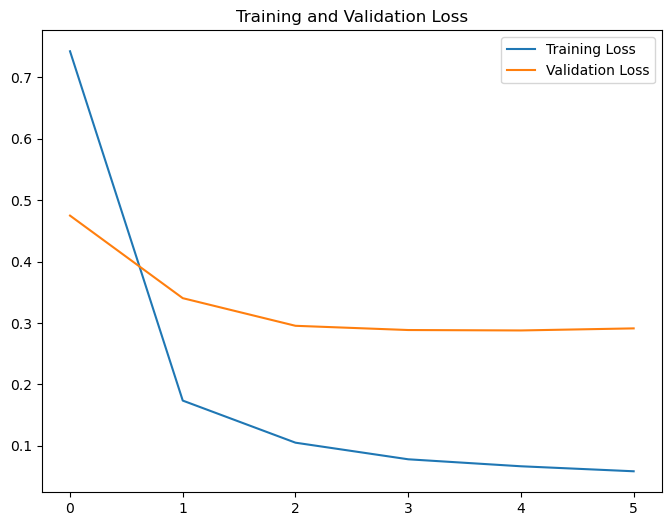

In [40]:
train(['inceptionv3', 'nasnetmobile', 'mobilenetv2'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 1021s 3s/step - accuracy: 0.7730 - loss: 1.1147 - val_accuracy: 0.9087 - val_loss: 0.4154
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 983s 3s/step - accuracy: 0.9544 - loss: 0.2052 - val_accuracy: 0.9221 - val_loss: 0.3298
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 984s 3s/step - accuracy: 0.9744 - loss: 0.1112 - val_accuracy: 0.9256 - val_loss: 0.3052
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 985s 3s/step - accuracy: 0.9759 - loss: 0.0867 - val_accuracy: 0.9321 - val_loss: 0.2754
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 980s 3s/step - accuracy: 0.9827 - loss: 0.0573 - val_accuracy: 0.9344 - val_loss: 0.2806


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_inceptionresnetv2_inceptionv3_xception.h5


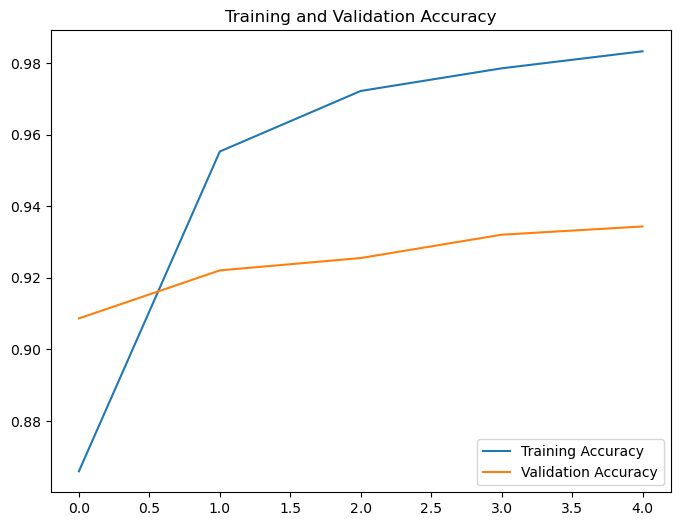

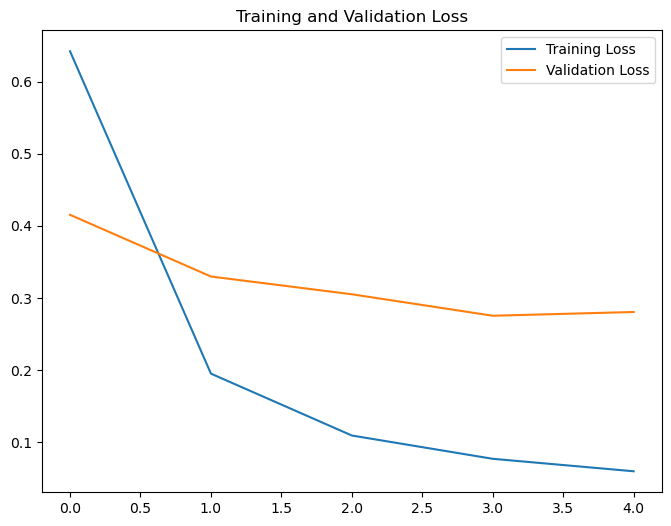

In [41]:
train(['inceptionresnetv2', 'inceptionv3', 'xception'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 849s 3s/step - accuracy: 0.7156 - loss: 1.4258 - val_accuracy: 0.8860 - val_loss: 0.6061
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.9461 - loss: 0.3384 - val_accuracy: 0.9029 - val_loss: 0.4562
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 815s 3s/step - accuracy: 0.9701 - loss: 0.2015 - val_accuracy: 0.9125 - val_loss: 0.3978
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 820s 3s/step - accuracy: 0.9810 - loss: 0.1220 - val_accuracy: 0.9217 - val_loss: 0.3645
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 816s 3s/step - accuracy: 0.9851 - loss: 0.0923 - val_accuracy: 0.9163 - val_loss: 0.3421
Epoch 6/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 819s 3s/step - accuracy: 0.9878 - loss: 0.0694 - val_accuracy: 0.9275 - val_loss: 0.3441


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_xception_densenet121_inceptionv3.h5


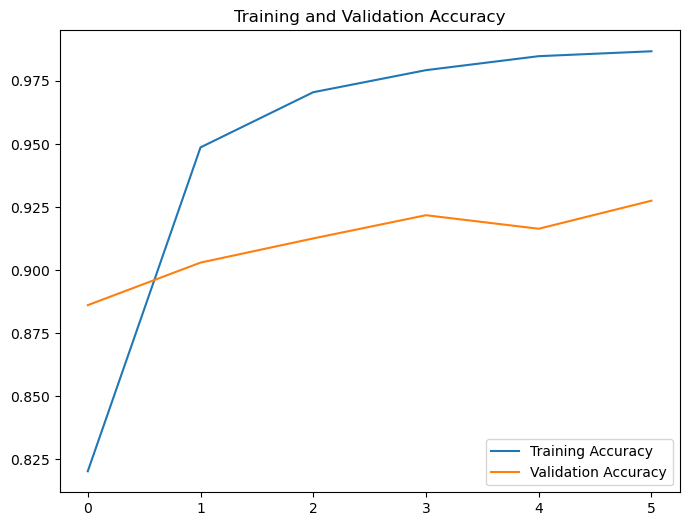

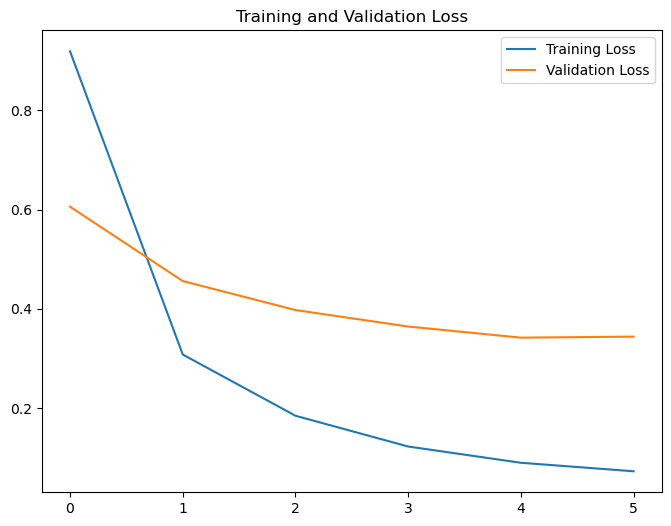

In [42]:
train(['xception', 'densenet121', 'inceptionv3'])

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 725s 2s/step - accuracy: 0.7686 - loss: 1.1552 - val_accuracy: 0.9190 - val_loss: 0.3338
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 673s 2s/step - accuracy: 0.9692 - loss: 0.1555 - val_accuracy: 0.9305 - val_loss: 0.2952
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 674s 2s/step - accuracy: 0.9788 - loss: 0.0947 - val_accuracy: 0.9428 - val_loss: 0.2656
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 679s 2s/step - accuracy: 0.9854 - loss: 0.0676 - val_accuracy: 0.9421 - val_loss: 0.2668


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_mobilenetv2_inceptionresnetv2_nasnetmobile.h5


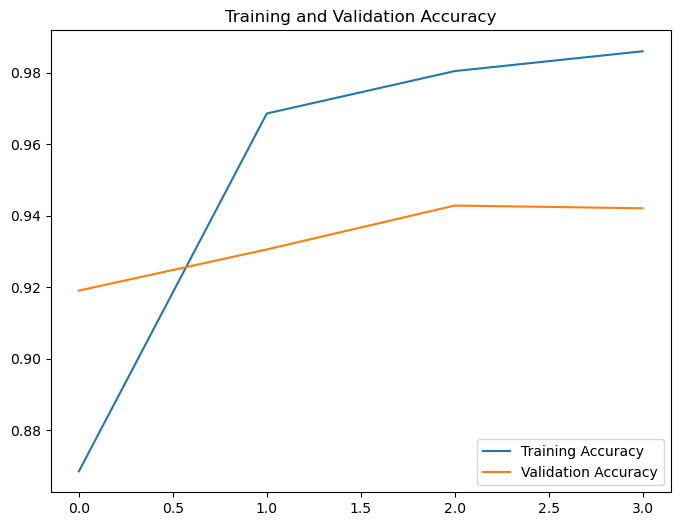

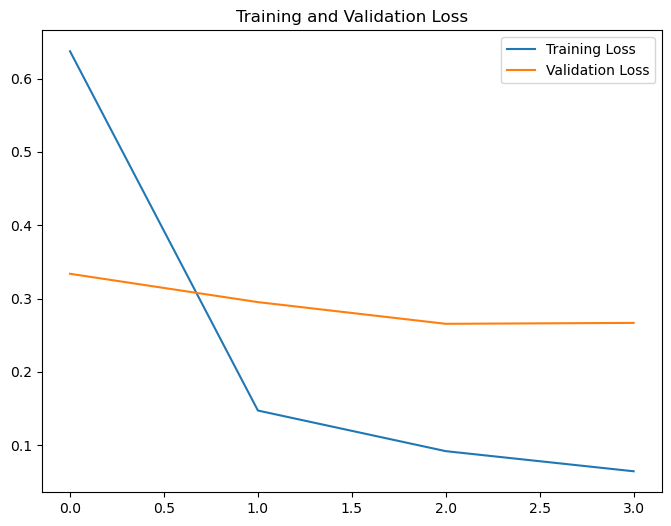

In [43]:
train(['mobilenetv2', 'inceptionresnetv2', 'nasnetmobile'])

# 3 Worst Models
Now we create an ensemble combining the 3 worst performing models to see the results.

Their individual validation accuracies were: 

efficientnetb0 - 01.57% | resnet50 - 04.34% | vgg19 - 34.54%

Found 10279 validated image filenames belonging to 73 classes.
Found 2606 validated image filenames belonging to 73 classes.
Epoch 1/10


C:\Users\josej\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


322/322 ━━━━━━━━━━━━━━━━━━━━ 1585s 5s/step - accuracy: 0.0267 - loss: 4.4698 - val_accuracy: 0.0549 - val_loss: 3.9027
Epoch 2/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1564s 5s/step - accuracy: 0.1042 - loss: 3.4759 - val_accuracy: 0.0975 - val_loss: 3.6157
Epoch 3/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1539s 5s/step - accuracy: 0.2063 - loss: 2.8964 - val_accuracy: 0.1067 - val_loss: 3.4688
Epoch 4/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1421s 4s/step - accuracy: 0.1741 - loss: 2.5411 - val_accuracy: 0.0952 - val_loss: 3.3902
Epoch 5/10
322/322 ━━━━━━━━━━━━━━━━━━━━ 1421s 4s/step - accuracy: 0.3080 - loss: 2.2816 - val_accuracy: 0.0625 - val_loss: 3.4172


Ensemble model saved to: C:\Users\josej\Thesis\models\ensemble_efficientnetb0_resnet50_vgg19.h5


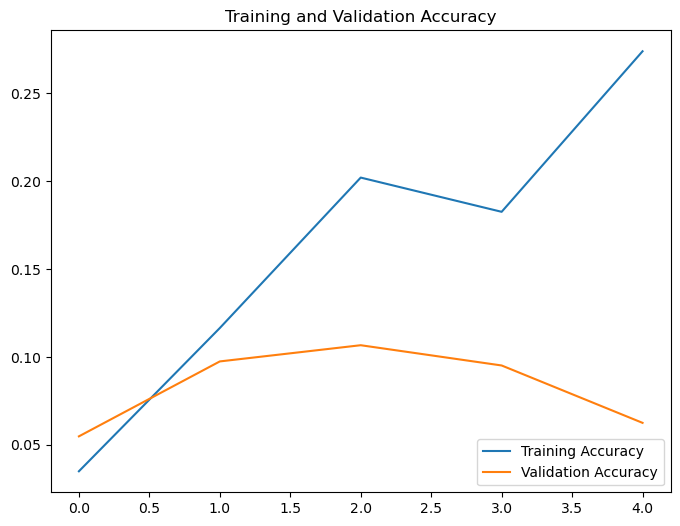

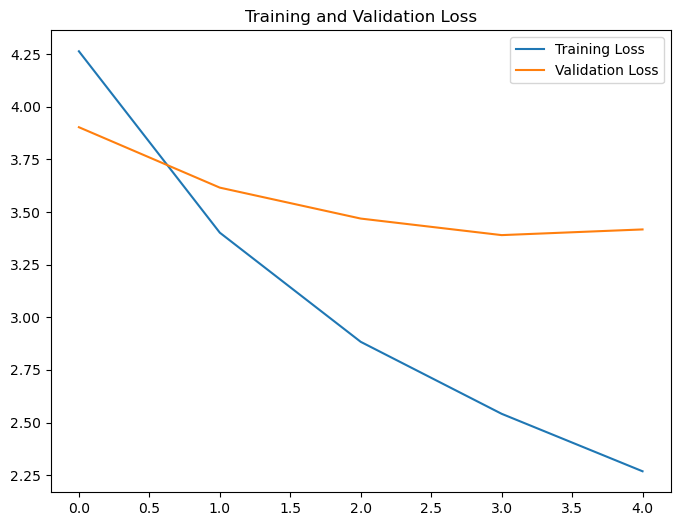

In [74]:
train(['efficientnetb0', 'resnet50', 'vgg19'])